In [3]:
import torch
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torchvision import transforms
from miniai.imports import *
from miniai.datasets import *
from miniai.diffusion2 import *

/home/galvanized_heart/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
xl,yl = 'image','label'
name = "zh-plus/tiny-imagenet"
dsd = load_dataset(name)


In [5]:
# Use to practice on a subset of the data without replacement
torch.manual_seed(42)
t_range = torch.ones(100_000,)
t_samps = 10_000
rand_t = torch.multinomial(t_range, t_samps, replacement=False)
v_range = torch.ones(10_000,)
v_samps = 1_000
rand_v = torch.multinomial(v_range, v_samps, replacement=False)
dsd["train"] = dsd["train"].select(rand_t)
dsd["valid"] = dsd["valid"].select(rand_v)
rand_t, rand_v

(tensor([18332, 76382, 79906,  ..., 93972,  9483, 83263]),
 tensor([5138, 7445, 1650, 9030, 7169, 1437,  801, 7389, 7041, 7291, 5541,  454,
         2706, 9958, 1359, 7764, 4764, 2496, 3542, 4047, 8407, 7315,  312, 1586,
         6831, 2303, 7441, 4069, 5953, 3244, 8656, 8898, 6172, 8598, 9581, 6308,
         2829, 6367, 5435,  644, 5073, 1358, 2219, 3758, 8510, 4510, 7339,  293,
         2733, 8475, 3846, 5740, 2903, 6733, 2227, 7002, 3728, 8844, 5563, 2982,
         8388, 6338,  185, 3438, 3353,  855, 9797, 1370, 8715, 8650,  322, 1748,
         7237, 6177, 8966, 2713, 7376, 3241, 5007, 3801, 8775,  182,  170, 1724,
         1725, 3294, 6555, 9978,  995, 3348, 8175, 1422, 4786, 6028, 4168, 7257,
         7437, 2431, 5395, 2654, 1039, 3223, 6340, 9016, 5208, 9019,  700, 2447,
         9712, 2637, 3627, 3217, 2034, 9836,  573, 8286, 6388, 1931,  256, 9132,
         9843, 3486, 6527, 1504, 8605, 4427, 7367, 2373,   90,  462, 8847, 5024,
         7685, 3693, 7703, 8926, 5365, 2462, 9902,

In [3]:
"""
# Use to practice on a subset of the data with replacement
torch.manual_seed(42)
rand_t = torch.randint(100000,(10000,))
rand_v = torch.randint(10000,(1000,))
dsd["train"] = dsd["train"].select(rand_t)
dsd["valid"] = dsd["valid"].select(rand_v)
rand_t, rand_v
"""

(tensor([37542, 26067, 86876,  ..., 81909, 37149,  5940]),
 tensor([1698,  775,  662, 2655, 3103, 4258, 7717,  739, 6954, 9860, 4506, 2676,
         3887, 8134, 9370, 8804,  874, 7998, 4287, 7890, 6121, 8100, 1622, 7316,
         1156, 8664, 3006, 5314, 5116, 5333, 1552, 4505, 9652, 4583, 9524, 2824,
         5002, 7125, 2375, 3225, 1575, 9228, 2962,  550, 9725, 5446, 4605, 3785,
         9131, 2773, 3099, 7094, 5389, 9841, 8872, 3657,  713, 3120, 2400, 7330,
         9277, 5230, 5138, 1040,  795, 5894, 5187, 7705, 1196, 2705, 9721, 2996,
         9013, 6520,  291, 7937, 1940, 7074, 2961, 3035, 5856, 9881, 5025, 9125,
         4087, 4988, 3074, 9626, 4878, 4344, 5406, 9579, 4280, 2513, 2823, 8857,
         9722, 6107, 1028, 8835, 6137, 2580, 7715, 3791, 5927, 6403, 7452, 9945,
         2411, 8908, 8909, 6623, 9445, 6545, 9940,  549, 6996, 5515, 3697, 2653,
         6198, 4083,  711, 5510,  534, 3800, 1008, 6713, 9589, 7637,  885, 4732,
         7355, 7397, 7963, 4329, 1542, 9981, 2633,

In [4]:
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})

In [5]:
@inplace
def transformi(b):
    img = [(torch.ones(3,1,1)*TF.to_tensor(o)).flatten() for o in b[xl]]
    b[yl] = b[xl] = img

def collate_fn(b):
    b = default_collate(b)
    return b[xl], b[xl]

def _dl(ds): 
    return DataLoader(ds, batch_size=20, collate_fn=collate_fn, num_workers=0)

tdsd = dsd.with_transform(transformi)
dls = DataLoaders(_dl(tdsd['train']), _dl(tdsd['valid']))

In [6]:
dl = dls.train
xb, yb = b = next(iter(dl))
[o.shape for o in b]

[torch.Size([20, 12288]), torch.Size([20, 12288])]

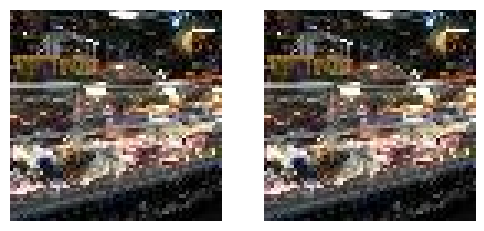

In [7]:
show_images((xb[0].reshape(3,64,64), yb[0].reshape(3,64,64)));

In [8]:
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d,nn.Linear)): init.kaiming_normal_(m.weight, a=leaky)
    
iw = partial(init_weights, leaky=0.2)

In [9]:
class VAE(nn.Module):
    def __init__(self, ni, nh, nl):
        super().__init__()
        self.enc = nn.Sequential(lin(ni, nh), lin(nh, nh))
        self.mu,self.lv = lin(nh, nl, act=None),lin(nh, nl, act=None)
        self.dec = nn.Sequential(lin(nl, nh), lin(nh, nh), lin(nh, ni, act=None))
        iw(self)
        
    def forward(self, x):
        x = self.enc(x)
        mu, lv = self.mu(x), self.lv(x)
        z = mu + (0.5*lv).exp()*torch.randn_like(lv)
        return self.dec(z), mu, lv

In [10]:
def kld_loss(inp, x):
    x_hat, mu, lv = inp
    return -0.5 * (1 + lv - mu.pow(2) - lv.exp()).mean()

def bce_loss(inp, x): 
    return F.binary_cross_entropy_with_logits(inp[0], x)

def vae_loss(inp, x): 
    return kld_loss(inp, x) + bce_loss(inp, x)

In [11]:
_, ni = b[0].shape
opt_func = partial(optim.Adam, eps=1e-5)
lr = 1e-5
epochs = 20
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
model = VAE(ni, ni//2, ni//4)
learn = Learner(model, dls, vae_loss, lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.694,0,train
0.694,0,eval
0.693,1,train
0.693,1,eval
0.691,2,train
0.688,2,eval
0.685,3,train
0.682,3,eval
0.682,4,train
0.679,4,eval


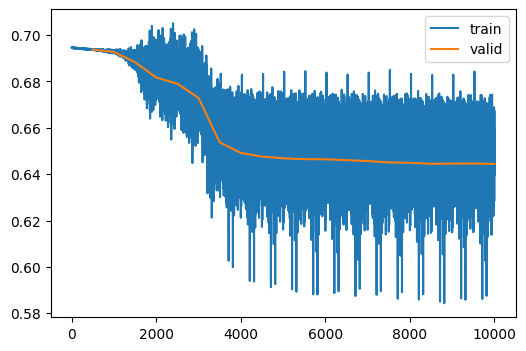

In [12]:
learn.fit(epochs)

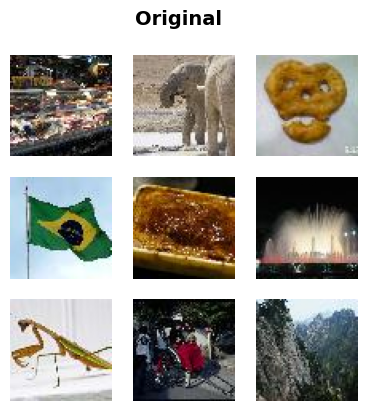

In [13]:
show_images(xb[:9].reshape(9,3,64,64), imsize=1.5, title='Original');

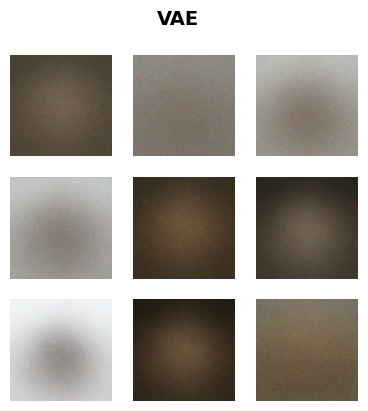

In [14]:
with torch.no_grad(): t,mu,lv = to_cpu(model(xb.cuda()))
t = t.float()
show_images(t[:9].reshape(9,3,64,64).sigmoid(), imsize=1.5, title='VAE');

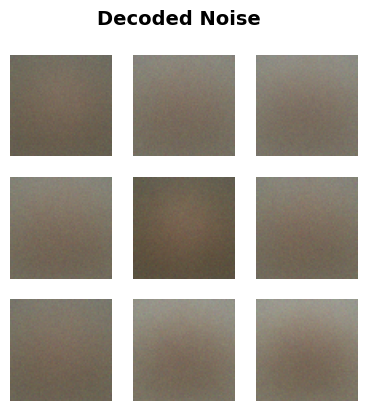

In [15]:
noise = torch.randn(9, ni//4).cuda()
with torch.no_grad(): ims = model.dec(noise).sigmoid()
show_images(ims.reshape(9,3,64,64), imsize=1.5, title='Decoded Noise');

In [18]:
xb[0].min(), xb[0].max()

(tensor(0.), tensor(1.))

In [19]:
xb[0].mean(), xb[0].std()

(tensor(0.3095), tensor(0.2491))

In [1]:
batch_size = 10
weights = torch.ones(100).expand(batch_size, -1)
m = torch.multinomial(weights, num_samples=3, replacement=False)

NameError: name 'torch' is not defined